Update: use NLTK to preprocess text data

In [1]:
# Import packages and libraries
import numpy as np
import random as rnd
import nltk as nk
import re

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn import metrics
from pprint import pprint
from copy import deepcopy

from Semi_EM_NB import Semi_EM_MultinomialNB
from time import time
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
# Load train and test data set with class labels 
train_Xy = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
test_Xy = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [3]:
def remove_noise(sentence):
    result = ''
    poster = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stopword_set = set(stopwords.words('english'))
    wordlist = re.sub(r"\n|(\\(.*?){)|}|[!$%^&*#()_+|~\-={}\[\]:\";'<>?,.\/\\]|[0-9]|[@]", ' ', sentence) # remove punctuation
    wordlist = re.sub('\s+', ' ', wordlist) # remove extra space
    wordlist_normal = [poster.stem(word.lower()) for word in wordlist.split()] # restore word to its original form (stemming)
    wordlist_normal = [lemmatizer.lemmatize(word, pos='v') for word in wordlist_normal] # restore word to its root form (lemmatization)
    wordlist_clean = [word for word in wordlist_normal if word not in stopword_set] # remove stopwords
    result = ' '.join(wordlist_clean)
    return result

In [4]:
# preprocess train and test text data
train_Xy.data_clean = map(remove_noise, train_Xy.data)
test_Xy.data_clean = map(remove_noise, test_Xy.data)

In [5]:
# Convert all text data into tf-idf vectors 
vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.95)
# vectorizer = TfidfVectorizer()
train_vec = vectorizer.fit_transform(train_Xy.data_clean)
test_vec = vectorizer.transform(test_Xy.data_clean)
print train_vec.shape, test_vec.shape

(11314, 11282) (7532, 11282)


In [6]:
# Divide train data set into labeled and unlabeled data sets
n_train_data = train_vec.shape[0]
split_ratio = 0.1 # labeled vs unlabeled
X_l, X_u, y_l, y_u = train_test_split(train_vec, train_Xy.target, train_size=split_ratio, stratify=train_Xy.target)
print X_l.shape, X_u.shape

(1131, 11282) (10183, 11282)


In [7]:
def cross_validation(clf, data_X, data_y, unlabeled=None, n_folds=5):
    print('=' * 80)
    print("Validation: ")
    print(clf)
    kf = StratifiedKFold(n_splits=n_folds)
    start_time = time()
    train_accuracies= list() # training accuracy
    fold_count = 1
    original_clf = deepcopy(clf)
    for train_ids, valid_ids in kf.split(data_X, data_y):
        cv_clf = deepcopy(original_clf)
        print("Fold # %d" % fold_count)
        fold_count += 1
        train_X, train_y, valid_X, valid_y = data_X[train_ids], data_y[train_ids], data_X[valid_ids], data_y[valid_ids]
        if unlabeled==None:
            cv_clf.fit(train_X, train_y)
        else:
            cv_clf.fit(train_X, train_y, unlabeled)
        pred = cv_clf.predict(valid_X)
        train_accuracies.append(metrics.accuracy_score(valid_y, pred))
    train_time = time() - start_time
    print("Validation time: %0.3f seconds" % train_time)
    print("Average training accuracy: %0.3f" % np.mean(np.array(train_accuracies)))
    return train_accuracies, train_time

In [8]:
# Cross validation for Naive Bayes classifier 
# using labeled data set only
nb_clf = MultinomialNB(alpha=1e-2)
cross_validation(nb_clf, X_l, y_l)

Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.062 seconds
Average training accuracy: 0.607


([0.59307359307359309,
  0.63043478260869568,
  0.57205240174672489,
  0.59999999999999998,
  0.63888888888888884],
 0.06184101104736328)

In [9]:
# Cross validation for semisupervised EM Naive Bayes classifier 
# using both labeled and unlabeled data set
em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2) # semi supervised EM based Naive Bayes classifier
cross_validation(em_nb_clf, X_l, y_l, X_u)

Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Initial expected log likelihood = -4572603.488

EM iteration #1
	Expected log likelihood = -4196387.534
EM iteration #2
	Expected log likelihood = -4191793.659
EM iteration #3
	Expected log likelihood = -4191088.608
EM iteration #4
	Expected log likelihood = -4190755.252
EM iteration #5
	Expected log likelihood = -4190615.284
EM iteration #6
	Expected log likelihood = -4190564.104
EM iteration #7
	Expected log likelihood = -4190550.363
EM iteration #8
	Expected log likelihood = -4190550.363
Fold # 2
Initial expected log likelihood = -4579617.610

EM iteration #1
	Expected log likelihood = -4197803.827
EM iteration #2
	Expected log likelihood = -4193095.050
EM iteration #3
	Expected log likelihood = -4191669.548
EM iteration #4
	Expected log likelihood = -4191259.351
EM iteration #5
	Expected log likelihood = -4191159.558
EM iteration #6
	Expected log likelihood = -4191142.365
EM iteration #7
	Expected log

([0.64502164502164505,
  0.70434782608695656,
  0.59388646288209612,
  0.66222222222222227,
  0.70833333333333337],
 150.02702498435974)

In [10]:
# Evaluate original NB classifier using test data set
nb_clf = MultinomialNB(alpha=1e-2).fit(X_l, y_l)
pred = nb_clf.predict(test_vec)
print(metrics.classification_report(test_Xy.target, pred, target_names=test_Xy.target_names))
# pprint(metrics.confusion_matrix(test_Xy.target, pred))
print(metrics.accuracy_score(test_Xy.target, pred))

                          precision    recall  f1-score   support

             alt.atheism       0.42      0.32      0.36       319
           comp.graphics       0.56      0.59      0.58       389
 comp.os.ms-windows.misc       0.49      0.32      0.39       394
comp.sys.ibm.pc.hardware       0.40      0.68      0.51       392
   comp.sys.mac.hardware       0.50      0.51      0.50       385
          comp.windows.x       0.59      0.66      0.62       395
            misc.forsale       0.67      0.49      0.57       390
               rec.autos       0.59      0.52      0.55       396
         rec.motorcycles       0.41      0.57      0.48       398
      rec.sport.baseball       0.75      0.74      0.75       397
        rec.sport.hockey       0.86      0.79      0.82       399
               sci.crypt       0.69      0.63      0.66       396
         sci.electronics       0.50      0.34      0.40       393
                 sci.med       0.74      0.56      0.64       396
         

In [11]:
# Evaluate semi-supervised EM NB classifier using test data set
em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2).fit(X_l, y_l, X_u)
pred = em_nb_clf.predict(test_vec)
print(metrics.classification_report(test_Xy.target, pred, target_names=test_Xy.target_names))
# pprint(metrics.confusion_matrix(test_Xy.target, pred))
print(metrics.accuracy_score(test_Xy.target, pred))

Initial expected log likelihood = -4542714.417

EM iteration #1
	Expected log likelihood = -4194665.244
EM iteration #2
	Expected log likelihood = -4191367.504
EM iteration #3
	Expected log likelihood = -4190585.496
EM iteration #4
	Expected log likelihood = -4190344.718
EM iteration #5
	Expected log likelihood = -4190237.296
EM iteration #6
	Expected log likelihood = -4190144.389
EM iteration #7
	Expected log likelihood = -4190079.305
EM iteration #8
	Expected log likelihood = -4190052.077
EM iteration #9
	Expected log likelihood = -4190055.082
                          precision    recall  f1-score   support

             alt.atheism       0.52      0.28      0.37       319
           comp.graphics       0.57      0.58      0.58       389
 comp.os.ms-windows.misc       0.54      0.20      0.29       394
comp.sys.ibm.pc.hardware       0.27      0.85      0.41       392
   comp.sys.mac.hardware       0.60      0.37      0.46       385
          comp.windows.x       0.64      0.75      

In [25]:
# find the most informative features 
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
%matplotlib inline
def show_topK(classifier, vectorizer, categories, K=10):
    feature_names = np.asarray(vectorizer.get_feature_names())
    fig, axes = plt.subplots(figsize=(50, 40), nrows=5, ncols=4)
    for i, category in enumerate(categories):
        topK = np.argsort(classifier.coef_[i])[-K:]
        text = " ".join(feature_names[topK])
        print("%s: %s" % (category, text))
        wordcloud = WordCloud(max_font_size=40).generate(text)
        axes[i//4, i%4].imshow(wordcloud, interpolation='bilinear')
        axes[i//4, i%4].axis("off")
        axes[i//4, i%4].set_title(category, fontweight="bold", size=24)
    plt.show()

alt.atheism: peopl think men god religion atheist thi say moral islam
comp.graphics: thank thi know comput ani speedstar format use file graphic
comp.os.ms-windows.misc: program mous ftp printer thank font file use driver window
comp.sys.ibm.pc.hardware: use thank ide thi card mb control scsi bu drive
comp.sys.mac.hardware: mhz powerbook mail work doe thi duo use appl mac
comp.windows.x: openwindow problem thi xterm server motif program file run window
misc.forsale: use price mm new condit ship ask pleas offer sale
rec.autos: buy know honda want automat dealer ani wa drive car
rec.motorcycles: helmet tank buy like bmw drink wa dod ride bike
rec.sport.baseball: win hit play year hi fan basebal wa team game
rec.sport.hockey: leagu thi nhl ulf wa play game player hockey team
sci.crypt: secur phone know wiretap use clipper encrypt thi chip key
sci.electronics: power compani radio inform wa catalog tv use thi detector
sci.med: cadr jxp chastiti skeptic dsl diseas sure ha medic thi
sci.space

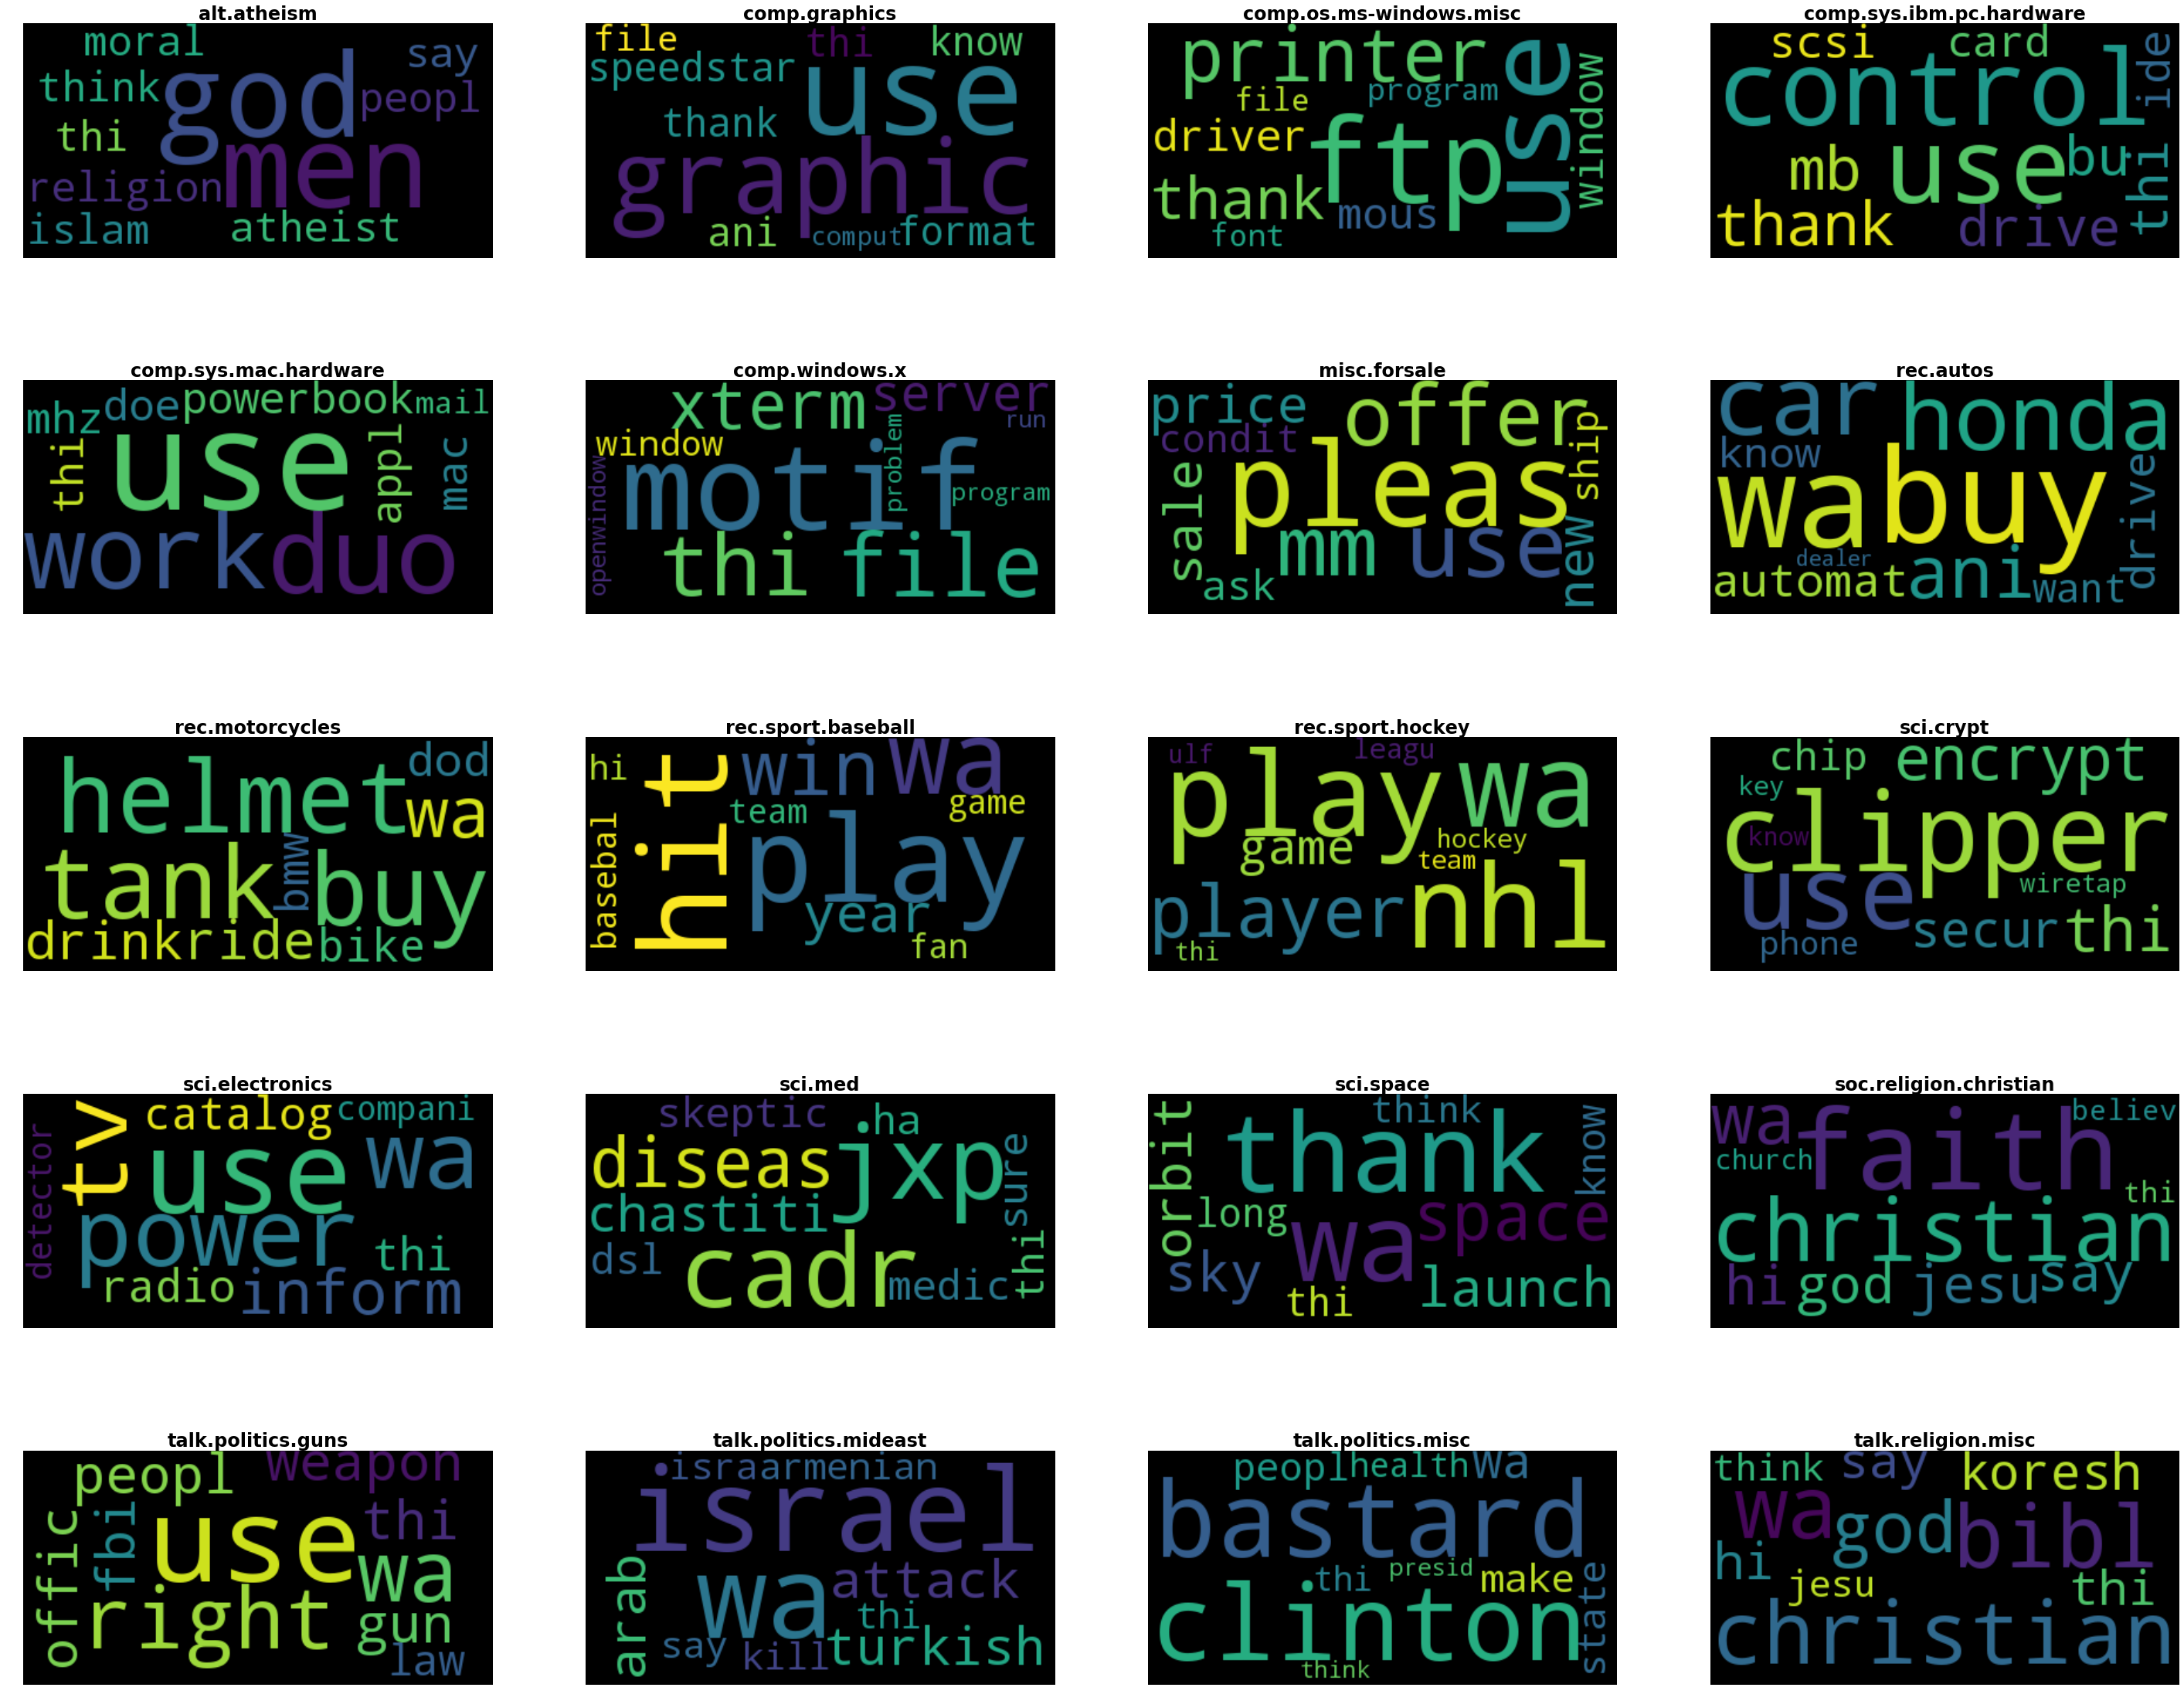

In [28]:
show_topK(nb_clf, vectorizer, train_Xy.target_names, K=10) # keywords for each class by original NB classifier

alt.atheism: atheism peopl wa atheist think islam god say thi moral
comp.graphics: look format use program thank thi ani graphic imag file
comp.os.ms-windows.misc: zip printer thi thank font ftp use driver file window
comp.sys.ibm.pc.hardware: window ani disk thank mb scsi use thi card drive
comp.sys.mac.hardware: problem thank card printer ani modem thi use appl mac
comp.windows.x: ani run file widget motif program server thi use window
misc.forsale: email price game pleas includ condit ship sell offer sale
rec.autos: price ani buy dealer like engin drive thi wa car
rec.motorcycles: think know like helmet dod thi motorcycl wa ride bike
rec.sport.baseball: win player thi hit hi pitch wa year team game
rec.sport.hockey: win thi nhl season wa player hockey play team game
sci.crypt: escrow phone govern secur use clipper thi chip encrypt key
sci.electronics: wa voltag current amp grind ani power circuit thi use
sci.med: dsl chastiti jxp patient pitt gordon diseas geb msg thi
sci.space: ear

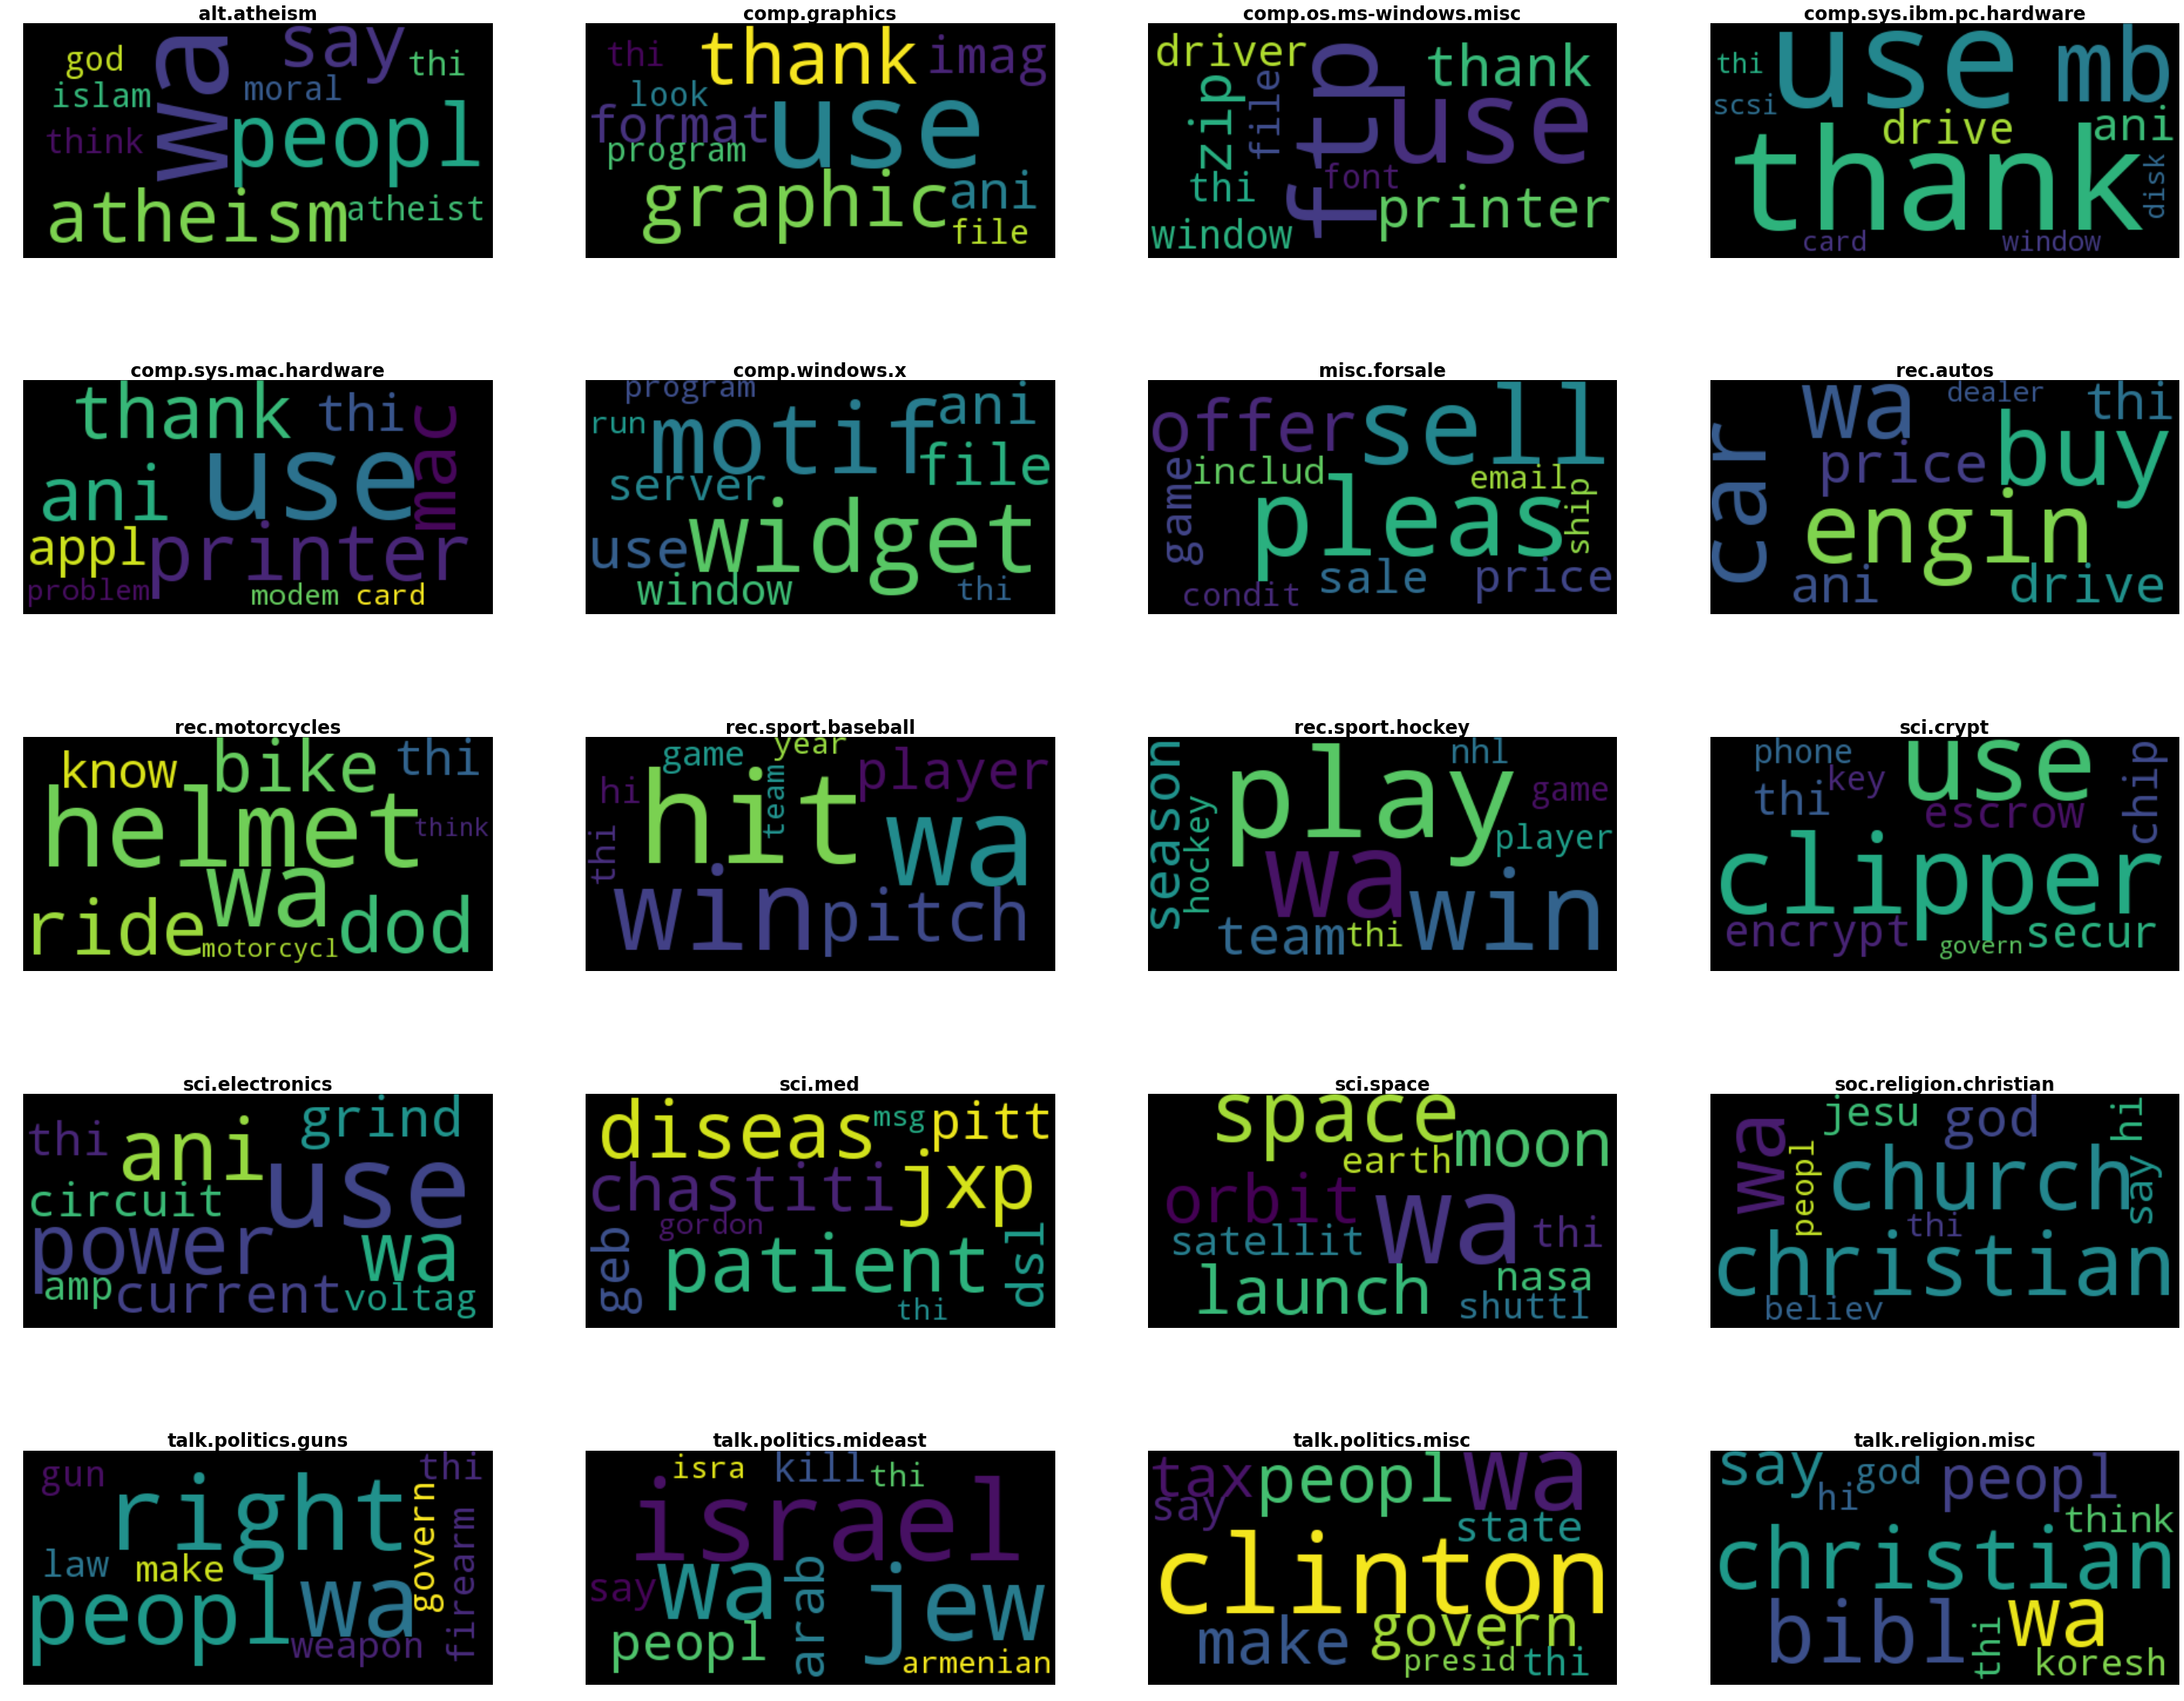

In [29]:
show_topK(em_nb_clf, vectorizer, train_Xy.target_names, K=10) # keywords for each class by semisupervised EM NB classifier